## Aggregate data from multiple sources

In [1]:
import numpy as np
import pandas as pd

### Johns Hopkins data

In [2]:
# data cleaning and summing total events by country
def preprocess_summation(df, description):
    df = df.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby(['Country/Region']).sum().reset_index()
    col_name = 'Total' + ' ' + description
    df[col_name] = df.apply(lambda r: sum(r[1:]), axis=1)
    df = df[['Country/Region', col_name]]
    df.columns = ['Country', col_name]
    df.replace({'Korea, South': 'South Korea', 'Czechia': 'Czech Republic', 'Taiwan*': 'Taiwan', 'US': 'United States'}, inplace=True)
    return df

In [3]:
df_confirmed = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
total_infections = preprocess_summation(df_confirmed, 'Infected')
total_infections.shape

(147, 2)

### Import 2018 GDP data
https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

In [4]:
df_gdp = pd.read_csv('./outside_data/GDP.csv')
df_gdp = df_gdp[['Country Name', '2018']]
df_gdp.columns = ['Country', 'GDP 2018']
df_gdp.replace({'Korea, Rep.': 'South Korea'}, inplace=True)
df_gdp.shape

(264, 2)

In [5]:
df = total_infections.merge(df_gdp, how='inner', on='Country')
df

,Country,Total Infected,GDP 2018
0,Afghanistan,74,1.936297e+10
1,Albania,160,1.510250e+10
2,Algeria,286,1.737580e+11
3,Andorra,14,3.236544e+09
4,Antigua and Barbuda,3,1.610574e+09


### Crime and Population data
https://worldpopulationreview.com/countries/crime-rate-by-country/

In [6]:
df_crime = pd.read_csv('./outside_data/crime_pop.csv', header=0, names=['Country', 'Crime Index', 'Population 2020'])
df = df.merge(df_crime, how='inner', on='Country')

In [7]:
df.head()

,Country,Total Infected,GDP 2018,Crime Index,Population 2020
0,Afghanistan,74,1.936297e+10,73.26,38928.346
1,Albania,160,1.510250e+10,40.02,2877.797
2,Algeria,286,1.737580e+11,54.41,43851.044
3,Argentina,202,5.198715e+11,62.96,45195.774
4,Armenia,67,1.243309e+10,20.78,2963.243


## Smoking data
https://ourworldindata.org/smoking#prevalence-of-smoking-across-the-world  
Note that the column of interest is percentage of country aged 15+ who smoke

In [8]:
df_smoke = pd.read_csv('./outside_data/smoking.csv', header=0, names=['Country', 'Code', 'Year', 'Smoking 2016'])
df_smoke = df_smoke[df_smoke.apply(lambda r: r['Year'] == 2016, axis=1)]
df_smoke.drop(['Code', 'Year'], axis=1, inplace=True)
df_smoke.shape

(186, 2)

In [9]:
df = df.merge(df_smoke, how='inner', on='Country')

### Gender data
https://data.worldbank.org/indicator/SP.POP.TOTL.FE.ZS
Percentage of females in 2018

In [20]:
df_gender = pd.read_csv('./outside_data/gender.csv')
df_gender = df_gender[['Country Name', '2018']]
df_gender.columns = ['Country', 'Females 2018']
df_gender.replace({'Korea, Rep.': 'South Korea'}, inplace=True)

In [21]:
df = df.merge(df_gender, how='inner', on='Country')

### Age data
https://worldpopulationreview.com/countries/median-age/

In [47]:
df_age = pd.read_csv('./outside_data/age.csv')
df_age = df_age[['Place', 'Median']]
df_age.columns = ['Country', 'Median Age']
df_age.shape

(214, 2)

In [48]:
df = df.merge(df_age, how='inner', on='Country')

In [67]:
df.to_csv('covid19.csv', index=False)

### Find Correlations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122a93810>,
      dtype=object)

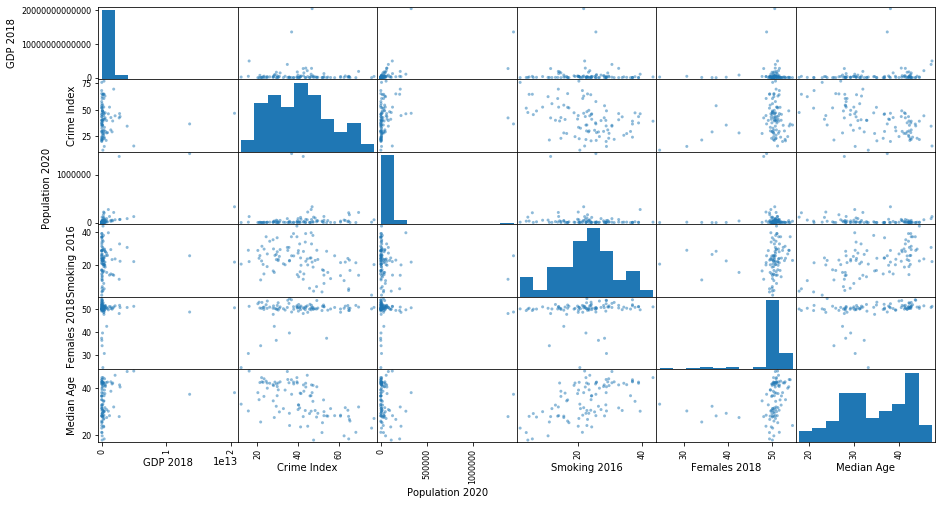

In [65]:
X = df[df.columns[2:]]
y = df['Total Infected']

